## 方策オフ型のSARSA

In [1]:
%load_ext lab_black

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../"))

import numpy as np
from collections import defaultdict, deque
from common.gridworld import GridWorld
from common.utils import greedy_action_probs

#### 方策オフ型のSARSAの実装

In [3]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(float)
        self.experience = deque(maxlen=2)

    def get_action(self, state):
        ps = self.b[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.experience.clear()

    def update(self, state, action, reward, done):
        self.experience.append((state, action, reward, done))
        if len(self.experience) < 2:
            return
        state, action, reward, done = self.experience[0]
        next_state, next_action, _, _ = self.experience[1]

        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        target = rho * (self.gamma * next_q + reward)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_action_probs(self.Q, state, 0)
        self.b[state] = greedy_action_probs(self.Q, state, self.epsilon)

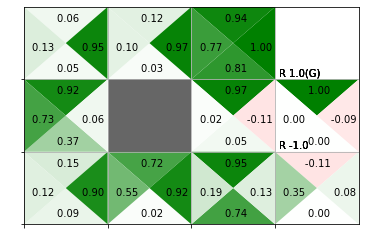

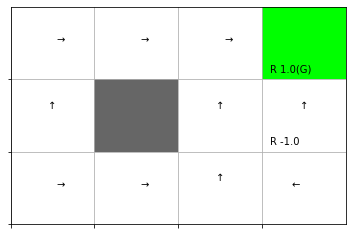

In [4]:
env = GridWorld()
experiences = deque(maxlen=2)
agent = SarsaOffPolicyAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)